# Part I - (San Francisco Ford GoBike Data Exploration)
## by (Saddick Kwao Umar)

## Introduction

This project seeks to analyse a dataset regarding Ford's GoBike bike sharing program around San Francisco Bay Area using exploratory data analysis techniques to uncover insights and make conclusions.

## Preliminary Wrangling


In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [2]:
# loading csv file
df = pd.read_csv('201902-fordgobike-tripdata.csv')
fordbikes = df.copy()

In [3]:
print(fordbikes.shape)
print(fordbikes.dtypes)

(183412, 16)
duration_sec                 int64
start_time                  object
end_time                    object
start_station_id           float64
start_station_name          object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             float64
end_station_name            object
end_station_latitude       float64
end_station_longitude      float64
bike_id                      int64
user_type                   object
member_birth_year          float64
member_gender               object
bike_share_for_all_trip     object
dtype: object


In [4]:
# chack and delete null values
fordbikes.isnull().sum()
fordbikes.dropna(inplace = True)

In [5]:
# checking duplicates
fordbikes.duplicated().sum()

0

Now lets convert data types, create new columns and drop columns not import to our analysis

In [6]:
# let's convert variables to the right datatypes

fordbikes['member_birth_year'] = fordbikes['member_birth_year'].astype(np.int64)
fordbikes['bike_id'] = fordbikes['bike_id'].astype(str)

# converting variables into categorical variables using a loop
cat_dtypes = ['user_type', 'member_gender', 'bike_share_for_all_trip']
for i in cat_dtypes:
    fordbikes[i] = fordbikes[i].astype("category")

# converting variables into pd.datetime variables using a loop
dates = ['start_time', 'end_time']
for i in dates:
    fordbikes[i] = pd.to_datetime(fordbikes[i])

In [7]:
# creating columns
fordbikes.insert(2, 'hour', fordbikes['start_time'].dt.hour)
fordbikes.insert(3, "day", fordbikes['start_time'].dt.day_name())
fordbikes.insert(16, "age", 2019 - fordbikes['member_birth_year'])

In [8]:
# dropping columns
columns = ['start_station_id', 'end_station_id', 'member_birth_year']
fordbikes.drop(columns = columns, inplace = True )

### What is the structure of your dataset?

> The dataset contains 183,412 records of trips, and 16 different features including start time, end time, start station, end station, and latitude/longitude for each station.The dataset contains few numeric variables and categorical variables.

### What is/are the main feature(s) of interest in your dataset?

> The main feature of interest is the duration of trips(in seconds) taken during the month of February, 2019

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> Certain features like age, gender, type of customer, time and date are major factors that would be leveraged to help support my investigation.

## Univariate Exploration

Let's look at the distribution of trips

Text(0.5, 0, 'duration_sec')

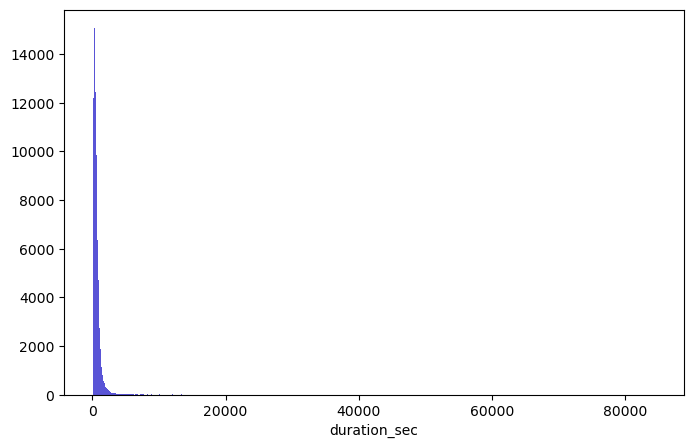

In [9]:
bins = np.arange(0, fordbikes['duration_sec'].max()+60, 60)

colors = '#5954d6'

plt.figure(figsize = [8, 5])
plt.hist(data = fordbikes, x = 'duration_sec', bins = bins, color = colors)
plt.xlabel('duration_sec')

Let's zoom in to see clear how values are distributed across trips duration

(0.0, 6000.0)

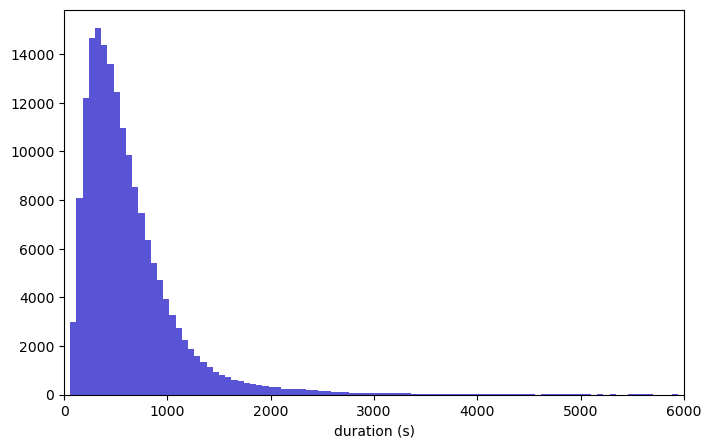

In [10]:
bins = np.arange(0, fordbikes['duration_sec'].max()+60, 60)

colors = '#5954d6'

plt.figure(figsize = [8, 5])
plt.hist(data = fordbikes, x = 'duration_sec', bins = bins, color = colors)
plt.xlabel('duration (s)')
plt.xlim(0, 6000)

The values are highly skewed, now lets transform it's scale using log transformation

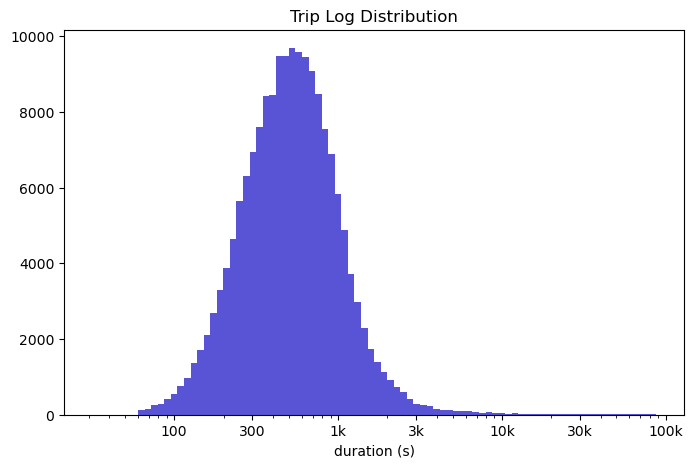

In [11]:
# checking summary stats
np.log(fordbikes.duration_sec.describe())

# investigate further with smaller bins size
bins = 10 ** np.arange(1.5, np.log10(fordbikes['duration_sec'].max())+0.040, 0.040)

plt.figure(figsize = [8, 5])
plt.hist(data = fordbikes, x = 'duration_sec', bins = bins, color = colors)
plt.xlabel('duration (s)')
plt.xscale('log')
plt.xticks([100, 300, 1e3, 3e3, 1e4, 3e4, 1e5], [100, 300, '1k', '3k', '10k', '30k', '100k'])
plt.title('Trip Log Distribution');

Trip duration distribution was far left due to it being highly skewed to the right, showing how it's mean is affected by outliers. After undergong log transformation, it could be observed that its distribution looks unimodal and most trips duration peaked in between 300 to 600.

Next, let's look at another variable of interest : Age

Text(0.5, 0, 'riders age')

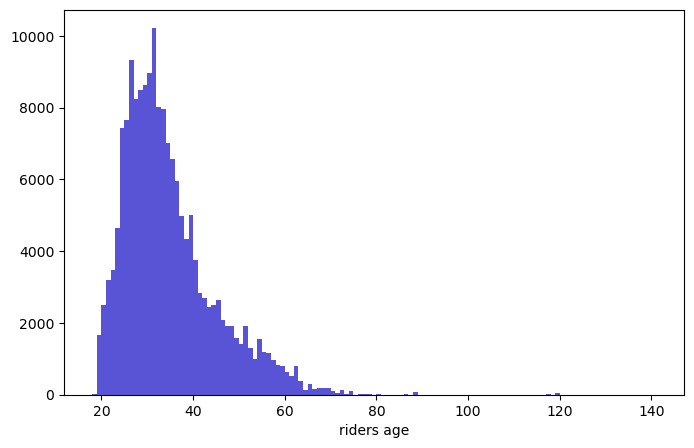

In [12]:
bins = np.arange(min(fordbikes['age']), max(fordbikes['age'])+1, 1)

plt.figure(figsize = [8, 5])
plt.hist(data = fordbikes, x = 'age', bins = bins, color = colors)
plt.xlabel('riders age')

The visualizations shows unevenly distribution of values in the age variable. Values are set far to the left depicting the availability of outliers in the far right.

Let's zoom into it

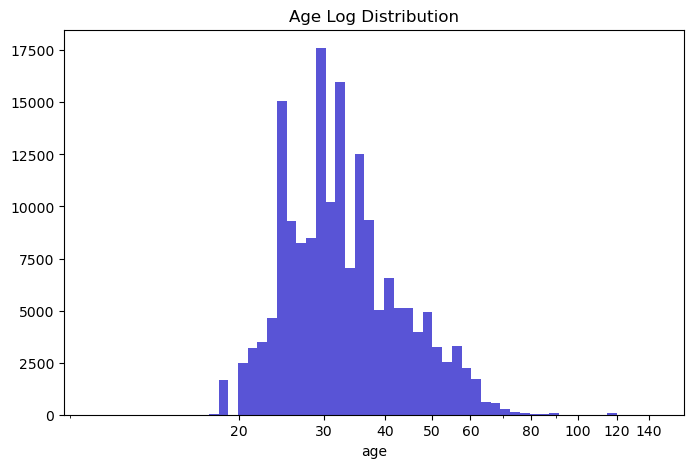

In [13]:
# let's limit the x-axis to zoom into the plot
bins = 10 ** np.arange(1, np.log10(fordbikes['age'].max())+0.02, 0.02)

plt.figure(figsize = [8, 5])
plt.hist(data = fordbikes, x = 'age', bins = bins, color = colors)
plt.xscale('log')
plt.xlabel('age')
plt.xticks([20, 30, 40, 50, 60, 80, 100, 120, 140], [20, 30, 40, 50, 60, 80, 100, 120, 140])
plt.title('Age Log Distribution');

Not much has changed, but after log transformation we can clearly see the spikes in years.

Let's remove outliers found in each variable

In [14]:
low_outliers = (fordbikes['duration_sec'] < 1500) & (fordbikes['age'] > 80)
print(low_outliers.sum())
fordbikes.loc[low_outliers, :].head()

187


,duration_sec,start_time,hour,day,end_time,start_station_name,start_station_latitude,start_station_longitude,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,age,member_gender,bike_share_for_all_trip
1285,148,2019-02-28 19:29:17.627,19,Thursday,2019-02-28 19:31:45.967,Shattuck Ave at Telegraph Ave,37.833279,-122.263490,Shattuck Ave at 55th St,37.840364,-122.264488,5391,Subscriber,119,Male,Yes
5197,217,2019-02-28 13:51:46.238,13,Thursday,2019-02-28 13:55:24.127,Central Ave at Fell St,37.773311,-122.444293,Broderick St at Oak St,37.773063,-122.439078,5801,Subscriber,88,Male,No
5266,384,2019-02-28 13:35:05.428,13,Thursday,2019-02-28 13:41:30.223,Duboce Park,37.769200,-122.433812,Broderick St at Oak St,37.773063,-122.439078,6608,Subscriber,88,Male,No
5447,147,2019-02-28 13:08:56.935,13,Thursday,2019-02-28 13:11:24.062,Duboce Park,37.769200,-122.433812,Page St at Scott St,37.772406,-122.435650,5018,Subscriber,88,Male,No
10827,1315,2019-02-27 19:21:34.436,19,Wednesday,2019-02-27 19:43:30.008,Bryant St at 2nd St,37.783172,-122.393572,Grove St at Masonic Ave,37.774836,-122.446546,6249,Subscriber,119,Male,No


Most of the low outlier values happen to be valid points. But, certain points are of extreme values like people about the age 80 years and above completing 7 to 8 minutes(2.4mil) trips within spaces of 2 or less minutes needs more investigating. An example is a subscriber with bike_id 5391

In [15]:
high_outliers = (fordbikes['duration_sec'] > 6000) | (fordbikes['age'] > 80)
print(high_outliers.sum())
fordbikes.loc[high_outliers, :].head()

895


,duration_sec,start_time,hour,day,end_time,start_station_name,start_station_latitude,start_station_longitude,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,age,member_gender,bike_share_for_all_trip
0,52185,2019-02-28 17:32:10.145,17,Thursday,2019-03-01 08:01:55.975,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,Commercial St at Montgomery St,37.794231,-122.402923,4902,Customer,35,Male,No
2,61854,2019-02-28 12:13:13.218,12,Thursday,2019-03-01 05:24:08.146,Market St at Dolores St,37.769305,-122.426826,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,5905,Customer,47,Male,No
3,36490,2019-02-28 17:54:26.010,17,Thursday,2019-03-01 04:02:36.842,Grove St at Masonic Ave,37.774836,-122.446546,Central Ave at Fell St,37.773311,-122.444293,6638,Subscriber,30,Other,No
199,15123,2019-02-28 18:23:19.035,18,Thursday,2019-02-28 22:35:22.294,The Embarcadero at Bryant St,37.787168,-122.388098,Myrtle St at Polk St,37.785434,-122.419622,5380,Subscriber,39,Male,No
297,13061,2019-02-28 18:28:18.728,18,Thursday,2019-02-28 22:05:59.954,Post St at Kearny St,37.788975,-122.403452,Post St at Kearny St,37.788975,-122.403452,5830,Subscriber,32,Male,No


In [16]:
# removing both high and low outliers
fordbikes = fordbikes.loc[-low_outliers & -high_outliers]
fordbikes.head()

,duration_sec,start_time,hour,day,end_time,start_station_name,start_station_latitude,start_station_longitude,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,age,member_gender,bike_share_for_all_trip
4,1585,2019-02-28 23:54:18.549,23,Thursday,2019-03-01 00:20:44.074,Frank H Ogawa Plaza,37.804562,-122.271738,10th Ave at E 15th St,37.792714,-122.248780,4898,Subscriber,45,Male,Yes
5,1793,2019-02-28 23:49:58.632,23,Thursday,2019-03-01 00:19:51.760,4th St at Mission Bay Blvd S,37.770407,-122.391198,Broadway at Kearny,37.798014,-122.405950,5200,Subscriber,60,Male,No
6,1147,2019-02-28 23:55:35.104,23,Thursday,2019-03-01 00:14:42.588,Palm St at Willow St,37.317298,-121.884995,San Jose Diridon Station,37.329732,-121.901782,3803,Subscriber,36,Female,No
7,1615,2019-02-28 23:41:06.766,23,Thursday,2019-03-01 00:08:02.756,Washington St at Kearny St,37.795393,-122.404770,Valencia St at 21st St,37.756708,-122.421025,6329,Subscriber,30,Male,No
8,1570,2019-02-28 23:41:48.790,23,Thursday,2019-03-01 00:07:59.715,Washington St at Kearny St,37.795393,-122.404770,Valencia St at 21st St,37.756708,-122.421025,6548,Subscriber,31,Other,No


#### Re-plotting Distributions

Text(0.5, 0, 'duration (s)')

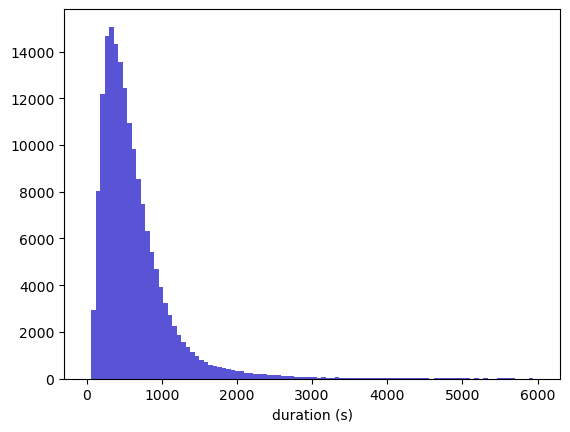

In [17]:
# re-plot the distribution of duration_sec
bins = np.arange(0, fordbikes['duration_sec'].max()+60, 60)

plt.hist(data = fordbikes, x = 'duration_sec', bins = bins, color = colors)
plt.xlabel('duration (s)')

Text(0.5, 0, 'riders age')

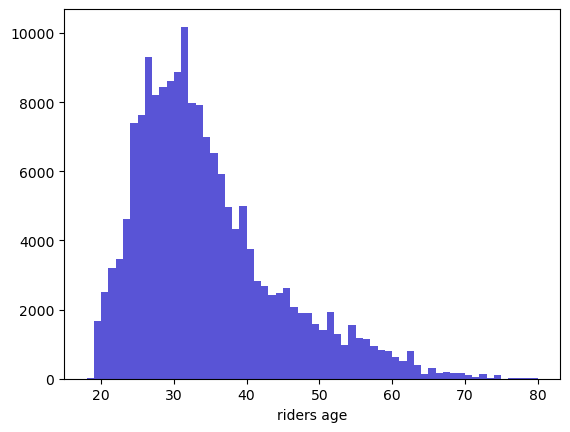

In [18]:
# re-plot the distribution of member_birth_year
bins = np.arange(min(fordbikes['age']), max(fordbikes['age'])+1, 1)
plt.hist(data = fordbikes, x = 'age', bins = bins, color = colors)
plt.xlabel('riders age')

Lets' look at and compare age distributions of bikers

In [19]:
# let's leverage pd.cut to create a new column for age ranges
bins = [15, 20, 25, 30, 40, 50, 60, 70, 80]
labels = ['Below 20 Years','18-25 Years', '25-30 Years', '30-40 Years', '40-50 Years', '50-60 Years', '60-70 Years', '70-80 Years']
fordbikes['age_ranges'] = pd.cut(fordbikes['age'], bins = bins, labels = labels)

In [20]:
# now let's filter both male and female gender seperately
mask1 = fordbikes['member_gender'] == 'Male'
mask2 = fordbikes['member_gender'] == 'Female'

males = fordbikes.loc[mask1]
females = fordbikes.loc[mask2]

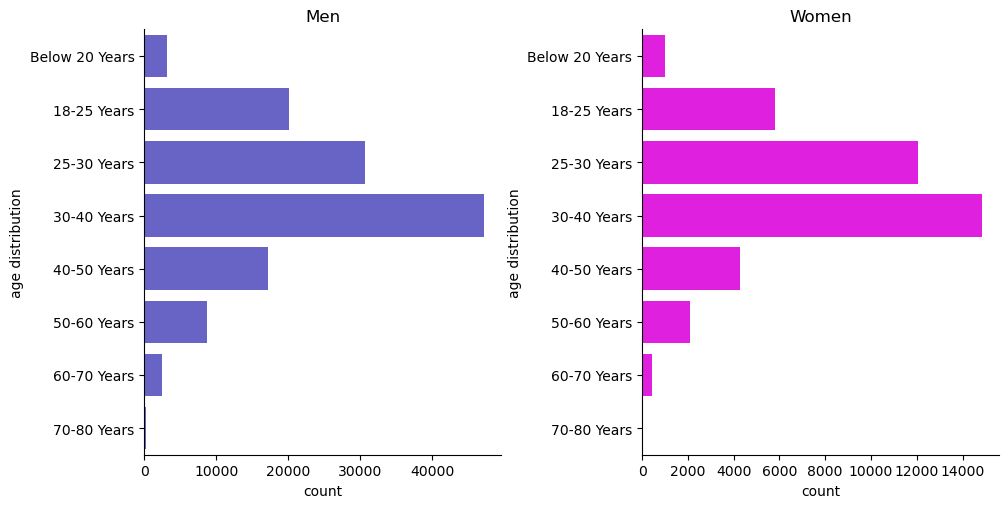

In [21]:
fig, ax = plt.subplots(ncols = 2, figsize = [10, 5])

sb.countplot(data = males, y = 'age_ranges', color = colors, ax = ax[0])
ax[0].set_title('Men')
ax[0].set_ylabel('age distribution')
sb.countplot(data = females, y = 'age_ranges', color = 'Magenta', ax = ax[1])
ax[1].set_title('Women')
ax[1].set_ylabel('age distribution')
sb.despine()
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

The visualization here shows the age distribution of Go Bike users in with large chunk of riders within the age of 30 to 40 in both gender.

Let's look at the trip frequency by 3 categorical variables day of the week, bike share for all trips and user type

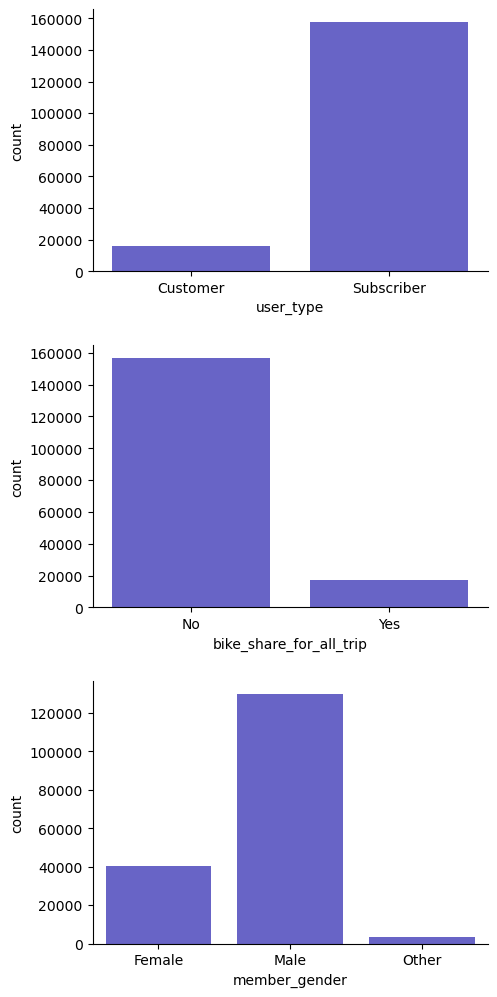

In [22]:
fig, ax = plt.subplots(nrows = 3, figsize = [5, 10])

cat_columns = ['user_type', 'bike_share_for_all_trip', 'member_gender']

for i in range(len(cat_columns)):
    var = cat_columns[i]
    sb.countplot(data = fordbikes, x = var, color = colors, ax = ax[i])
sb.despine()
plt.tight_layout(pad=0.8, w_pad=0.8, h_pad=2.2);

Let's look at the the distribution of these variables by ratio

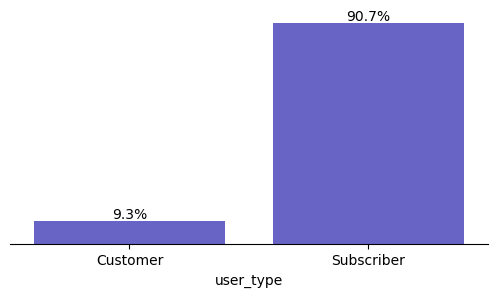

In [23]:
order = fordbikes['user_type'].value_counts(sort = False).index

plt.figure(figsize = [5,3])
g = sb.countplot(data = fordbikes, x = 'user_type', order = order, color = colors)
g.set(yticklabels = [])
g.set(ylabel = "")
plt.tick_params(left = False)

user_counts = fordbikes['user_type'].value_counts(sort = False)
total = fordbikes['user_type'].value_counts().sum()
locs, labels = plt.xticks()

for loc, label in zip(locs, labels):
    count =user_counts[loc]
    counts = user_counts[label.get_text()]
    percent_str = '{:0.1f}%'.format(100*count/total)
    plt.text(loc, counts+2, percent_str, ha = 'center', va = 'bottom', color = 'black')
sb.despine(left = True)
plt.tight_layout(pad=0.8, w_pad=1.8, h_pad=2.2);

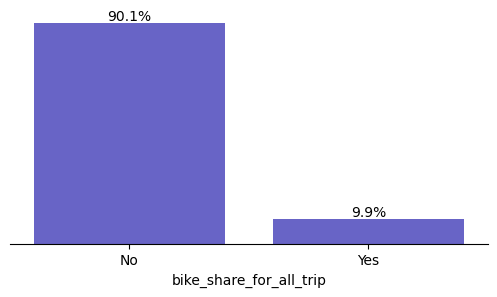

In [24]:
order = fordbikes['bike_share_for_all_trip'].value_counts().index

plt.figure(figsize = [5,3])
g = sb.countplot(data = fordbikes, x = 'bike_share_for_all_trip', order = order, color = colors)
g.set(yticklabels = [])
g.set(ylabel = "")
plt.tick_params(left = False)

user_counts = fordbikes['bike_share_for_all_trip'].value_counts()
total = fordbikes['bike_share_for_all_trip'].value_counts().sum()
locs, labels = plt.xticks()

for loc, label in zip(locs, labels):
    count =user_counts[loc]
    counts = user_counts[label.get_text()]
    percent_str = '{:0.1f}%'.format(100*count/total)
    plt.text(loc, counts+2, percent_str, ha = 'center', va = 'bottom', color = 'black')
sb.despine(left = True)
plt.tight_layout(pad=0.8, w_pad=1.8, h_pad=2.2);

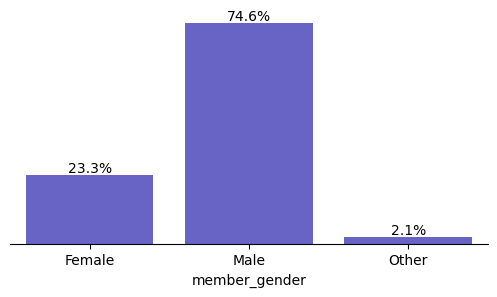

In [25]:
order = fordbikes['member_gender'].value_counts(sort = False).index

plt.figure(figsize = [5,3])
g = sb.countplot(data = fordbikes, x = 'member_gender', color = colors)
g.set(yticklabels = [])
g.set(ylabel = "")
plt.tick_params(left = False)

user_counts = fordbikes['member_gender'].value_counts(sort = False)
total = fordbikes['member_gender'].value_counts().sum()
locs, labels = plt.xticks()

for loc, label in zip(locs, labels):
    count =user_counts[loc]
    counts = user_counts[label.get_text()]
    percent_str = '{:0.1f}%'.format(100*count/total)
    plt.text(loc, counts+2, percent_str, ha = 'center', va = 'bottom', color = 'black')
sb.despine(left = True)
plt.tight_layout(pad=0.8, w_pad=1.8, h_pad=2.2);

Most Go Bike users tend to be under a subscription package. Yet, there's very less subscription for the "bike share for all" program. Moreover, cycling and bike share are often male dominated, and here is no exception.

Let's take a look at trips frequency by parts of the day and days in a week

In [26]:
# let's leverage on feature engineering to create an additional column 'day_periods' by using pandas.cut
bins = [0, 6, 12, 18, 24]
labels = ['Night', 'Morning', 'Afternoon', 'Evening']
day_periods = pd.cut(fordbikes['hour'], bins = bins, labels = labels, right = False)
fordbikes.insert(4, 'day_periods', day_periods)

In [27]:
# let's generate numbers in ascending order and use the ordering to order our created 'hour' column
order = fordbikes.hour.value_counts().index
order = order.sort_values().tolist()

In [28]:
# convert day_periods, day, and hour columns into ordered categorical types
ordinal_var_dict = {'day_periods' : ['Morning', 'Afternoon', 'Evening', 'Night'], 
                    'day' : ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                    'hour' : order}

for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered = True, categories = ordinal_var_dict[var] )
    fordbikes[var] = fordbikes[var].astype(ordered_var)

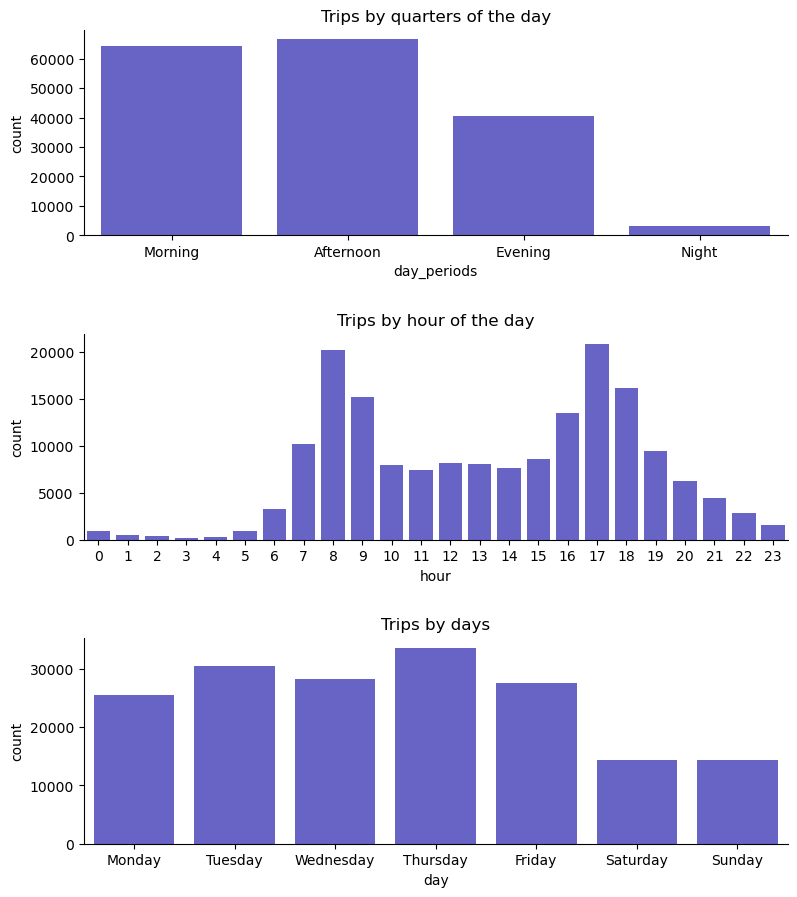

In [29]:
fig, ax = plt.subplots(nrows = 3, figsize = [8, 9], squeeze = True)

time_cols = ['day_periods', 'hour', 'day']

for i in range(len(time_cols)):
    var = time_cols[i]
    sb.countplot(data = fordbikes, x = var, color = colors, ax = ax[i])
    ax[i].set_title('Trips by quarters of the day')
    ax[1].set_title('Trips by hour of the day')
    ax[2].set_title('Trips by days')
plt.tight_layout(pad=0.8, w_pad=0.8, h_pad=2.5);
sb.despine()

Unsurprisingly, most trips were made during morning and afternoon. The peak in this periods shows that GoBike is popular with office commuters and students with frequency of bike sharing peaking at 8am to 9am during office and school going time and from 5pm to 6pm during office and school closing times.
Also, Thursdays happens to be most popular with riders, whilst there isn't much biking during weekends.

Most busiest start and end stations during the whole month of Febuary

In [30]:
start_st_idx = fordbikes['start_station_name'].value_counts().head(10).index
stations = fordbikes['start_station_name'].isin(start_st_idx)
popular_start_stations = fordbikes.loc[stations, :]

end_st_idx = fordbikes['end_station_name'].value_counts().head(10).index
stations = fordbikes['end_station_name'].isin(end_st_idx)
popular_end_stations = fordbikes.loc[stations, :]

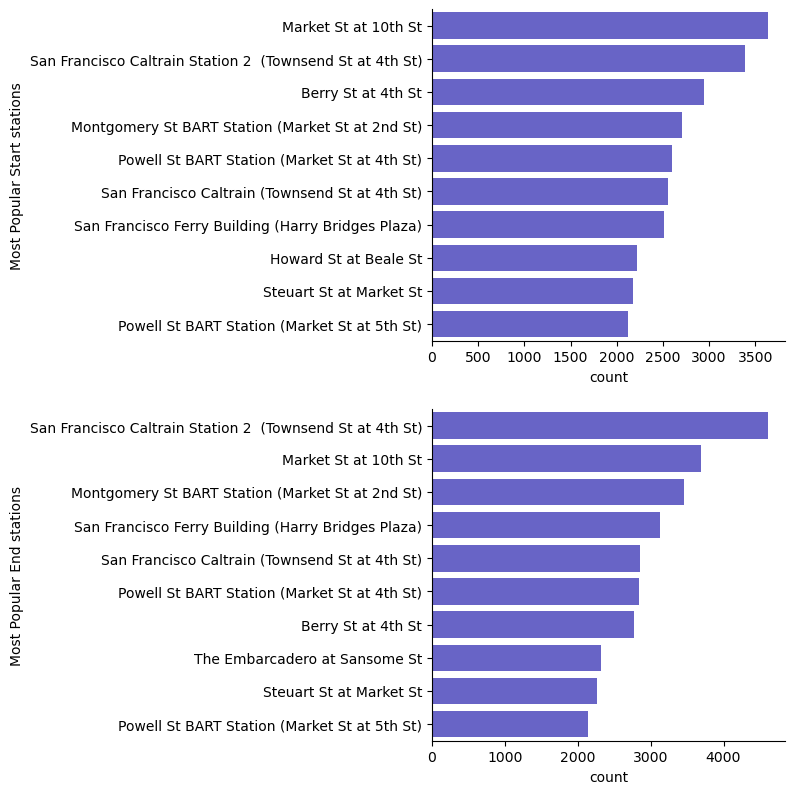

In [31]:
fig, ax = plt.subplots(nrows = 2, figsize = [8, 8])

sb.countplot(data = popular_start_stations, y = 'start_station_name',
             order = start_st_idx, color = colors, ax = ax[0])
ax[0].set_ylabel('Most Popular Start stations')
sb.countplot(data = popular_end_stations, y = 'end_station_name', 
             order = end_st_idx, color = colors, ax = ax[1])
ax[1].set_ylabel('Most Popular End stations')
sb.despine()
plt.tight_layout(pad=0.9, w_pad=0.8, h_pad=1.8);

Market St at 10th St and San Francisco Caltrain Station 2 dominated as the busiest stations depicting the most bike friendly areas in San Francisco. Powell St BART Station, the least bike friendly area

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> The trips duration variable took on large amounts of values making it impossible to determine it's distribution. After, log transformation, it was observed it shape was unimodal and that it peaks were between 400 to 500. From the age variable, most Go Bike users happen to be between ages of 30 to 40. However, ages of these users were unreasonably high. Distribution of other variables like day_periods, hour, day were also observed. This are additional variables added through feature engineering as available variables were insufficient. This helped determine fluctuations caused by user patronage during certain days or hours of the day.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> Distribution in duration_sec feature was placed far left showing how it was highly skewed to the right. When investigating age distribution, it was observed that ages of riders are exceeded normal age for a rider. Maximum age of riders was 140years. Those extreme values in were cleaned together with other outliers reducing riders age to maximum of 80 year. 

## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

In [32]:
categorical_vars = ['hour', 'day', 'day_periods', 'user_type', 'member_gender','bike_share_for_all_trip']
numeric_vars = ['duration', 'age']

#### Let's start by looking at the relationship between two numeric variables

Relationship between bikers by age and  trip frequency

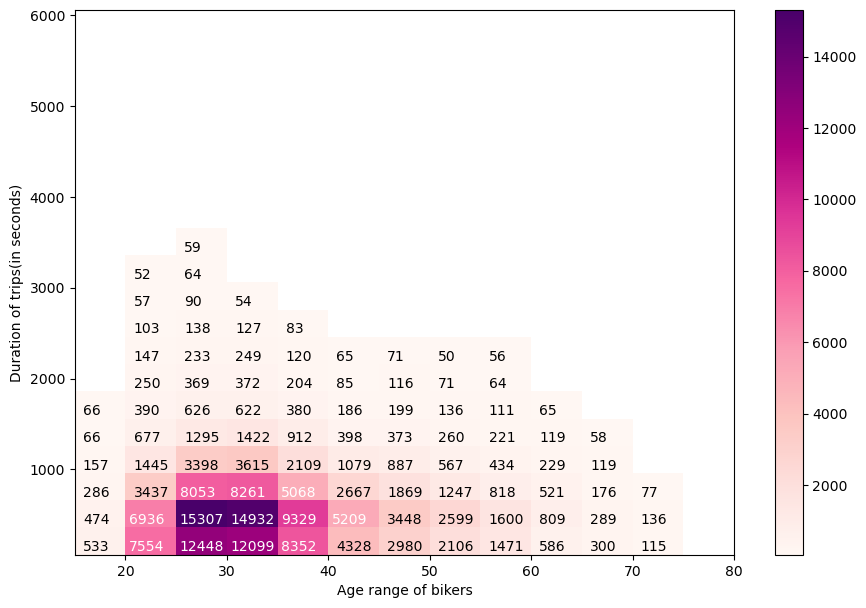

In [33]:
plt.figure(figsize = [9, 6])

bins_x = np.arange(15, fordbikes['age'].max()+5, 5)
bins_y = np.arange(60, fordbikes['duration_sec'].max()+300, 300)

hd2 = plt.hist2d(data = fordbikes, x = 'age', y = 'duration_sec', 
                 cmin = 50, cmap = 'RdPu', bins = [bins_x, bins_y])
plt.colorbar()
plt.xlabel('Age range of bikers')
plt.ylabel('Duration of trips(in seconds)')


counts = hd2[0]

for i in range(counts.shape[0]):
    for j in range(counts.shape[1]):
        c = counts[i, j]
        if c > 5000:
            plt.text(bins_x[i]+0.35, bins_y[j]+5.5, int(c),
                    ha = 'left', va = 'bottom', color = 'white')
        elif c > 0:
            plt.text(bins_x[i]+0.80, bins_y[j]+5.5, int(c),
                    ha = 'left', va ='bottom', color = 'black')
plt.tight_layout(pad=0.4, w_pad=0.8, h_pad=1.0)

Notice the negative trend between the bikers age and trip frequency. With peaks between 330 to 600 seconds and age ranging from 25 to 35, the heatmap depicts most trips taken to be short trips and by people within working class and college going age. Importantly, the visualization shows a less trips are taken has users age.

#### Let's look at the relationship between two categorical variables

Let's look at  ratio of trip taken by customer type by each day 

In [34]:
counts = fordbikes.groupby(['day', 'user_type']).size()
counts = counts.reset_index(name = 'count')
counts = pd.pivot(data = counts, index = 'day', columns = 'user_type', values = 'count')

# creating additional columns in percentages for customer and subscriber
counts['Customer_pc'] = 100*(counts['Customer']/(counts['Customer']+counts['Subscriber']))
counts['Subscriber_pc'] = 100*(counts['Subscriber']/(counts['Customer']+counts['Subscriber']))
counts = counts.reset_index()
counts = counts.set_index(keys = 'day')

# Now let's retrieve only ratio columns from the counts dataframe
trips_ratio = counts.loc[:, ['Customer_pc', 'Subscriber_pc']]

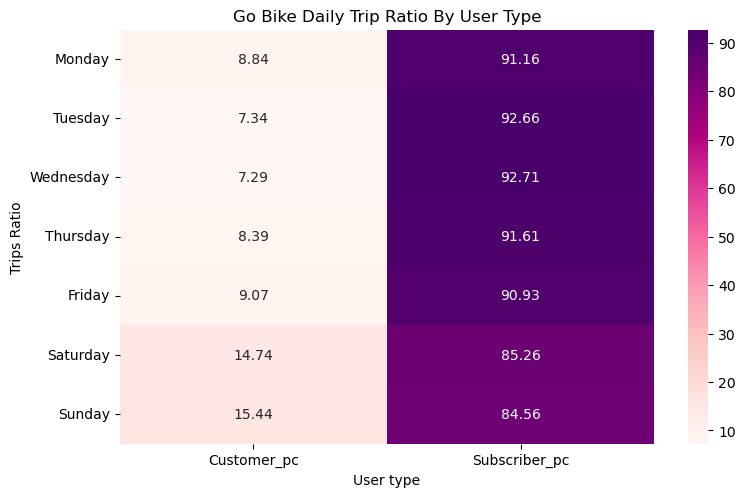

In [35]:
plt.figure(figsize = [8, 5])

sb.heatmap(data = trips_ratio, annot = True, fmt = '.2f', cmap = 'RdPu')
plt.xlabel('User type')
plt.ylabel('Trips Ratio')
plt.title('Go Bike Daily Trip Ratio By User Type')
plt.tight_layout(pad=0.8, w_pad=0.8, h_pad=2.2);

The visualization shows that casual riders tend to make 7% to 15% of the trips taken each day. This only shows they are unmotivated to subscribe to a package despite their tendencies to use bikes as means of transportation. To push unsuscribers towards subscription package, Go bikes might consider a little increase in unsuscriber fees.

#### Now, let's look at relationships between 3 categorical variables

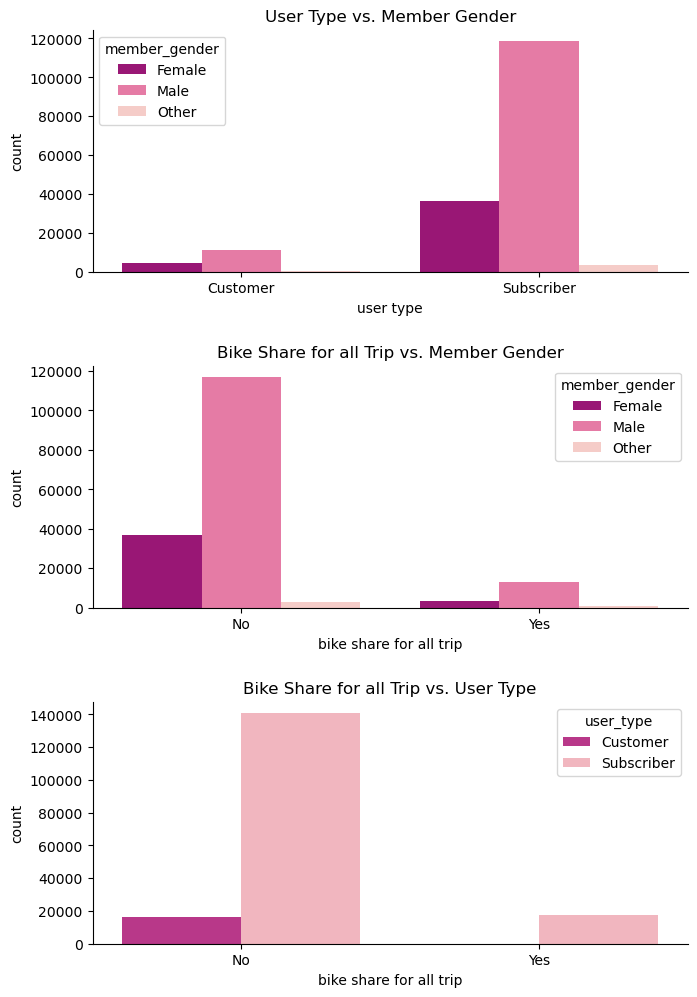

In [36]:
# let's look at the relationship between user_type, member_gender and bike_share_for_all_trips
plt.figure(figsize = [7, 10])

# subplot 1: user type vs member gender
plt.subplot(3, 1, 1)
sb.countplot(data = fordbikes, x = 'user_type', hue = 'member_gender', palette = 'RdPu_r')
plt.xlabel('user type')
plt.title('User Type vs. Member Gender')

# subplot 2: bike share for all trip vs. member gemder
plt.subplot(3, 1, 2)
sb.countplot(data = fordbikes, x = 'bike_share_for_all_trip', hue = 'member_gender', palette = 'RdPu_r')
plt.xlabel('bike share for all trip')
plt.title('Bike Share for all Trip vs. Member Gender')

# subplot 3: bike share for all trip vs. user type
plt.subplot(3, 1, 3)
sb.countplot(data = fordbikes, x = 'bike_share_for_all_trip', hue = 'user_type', palette = 'RdPu_r')
plt.xlabel('bike share for all trip')
plt.title('Bike Share for all Trip vs. User Type')
sb.despine()
plt.tight_layout(pad=0.8, w_pad=0.8, h_pad=2.2);

In the first subplot, it turns out that male gender tend to subscribe more to Go Bike's package than any other gender. In the second subplot, a large chunk of males declined 'bike_share_for_all_trips' program eventhough males dominate every other gender as subscribers. In third subplot, there happen not to be any interation between being a suscriber and prefering bikes for all trips. Despite being activate subscribers only few riders are willing to contemplate bikes for all trips.

Let's look at trips duration by day and periods of the day

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1209: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 1000x800 with 0 Axes>

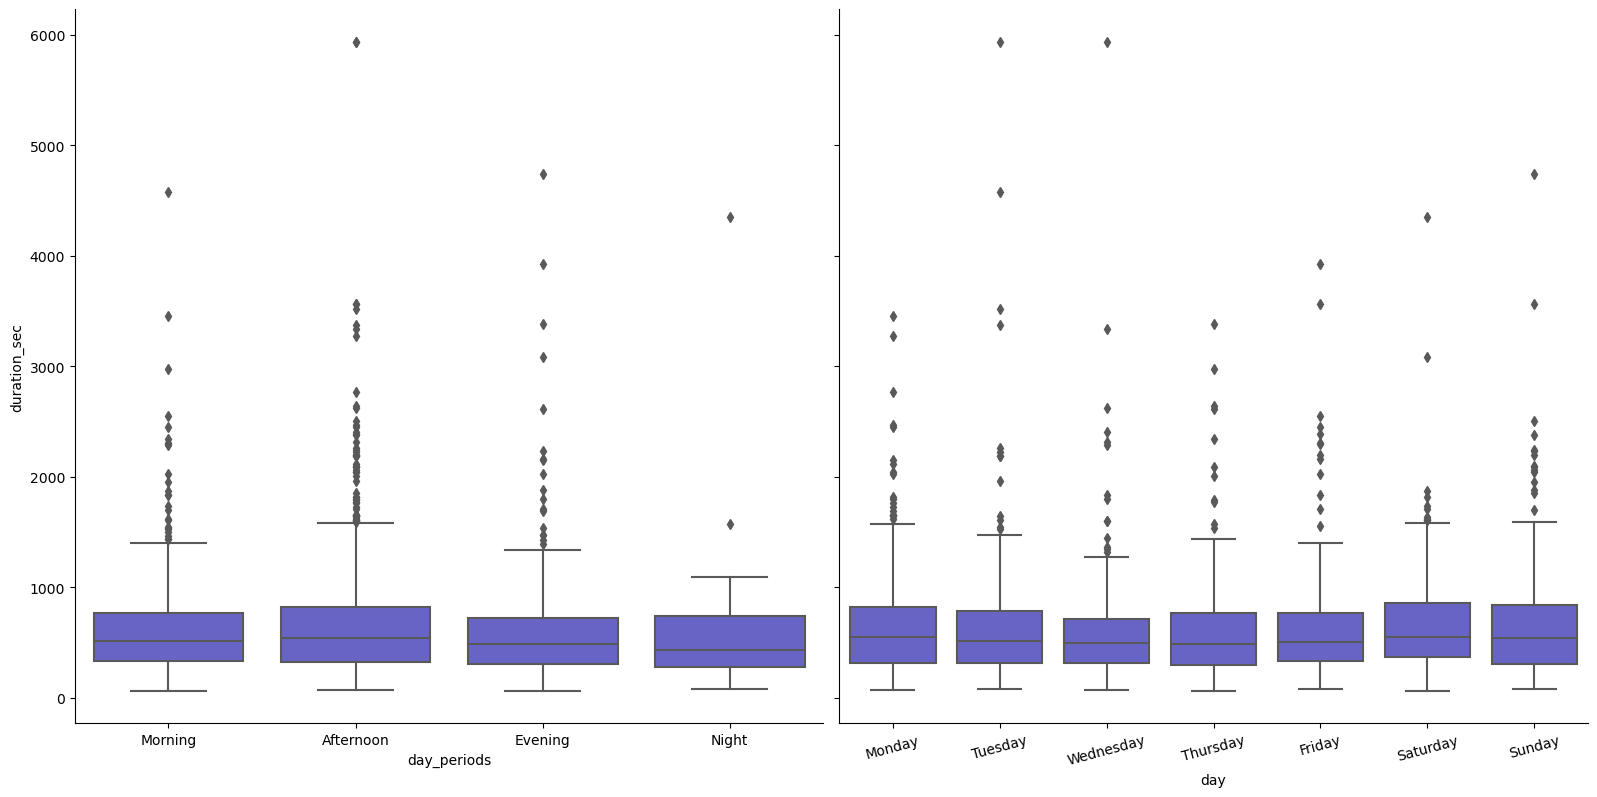

In [37]:
# lets sample from the fordbikes 
samples = np.random.choice(fordbikes.shape[0], 2000, replace = False)
fordbikes_samp = fordbikes.iloc[samples, :]
fordbikes_samp

# creatiing a boxgrid function to determine how trips duration interact with days and it's periods
def boxgrid(x, y, **kwargs):
    sb.boxplot(x, y, color = colors)

plt.figure(figsize = [10, 8])
g = sb.PairGrid(data = fordbikes_samp, x_vars = ['day_periods', 'day'], y_vars = 'duration_sec',
               size = 8, aspect = 1.0)
g.map(boxgrid)
plt.xticks(rotation = 15)
plt.tight_layout(pad=0.8, w_pad=0.8, h_pad=1.0);

By day periods, we can see the sameness in average duration of trips from morning to evening with the exception of night having less. By days, Saturdays have the highest average time spent on trips with Fridays and Thursdays having less which is understandable.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1209: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, 

<Figure size 1500x800 with 0 Axes>

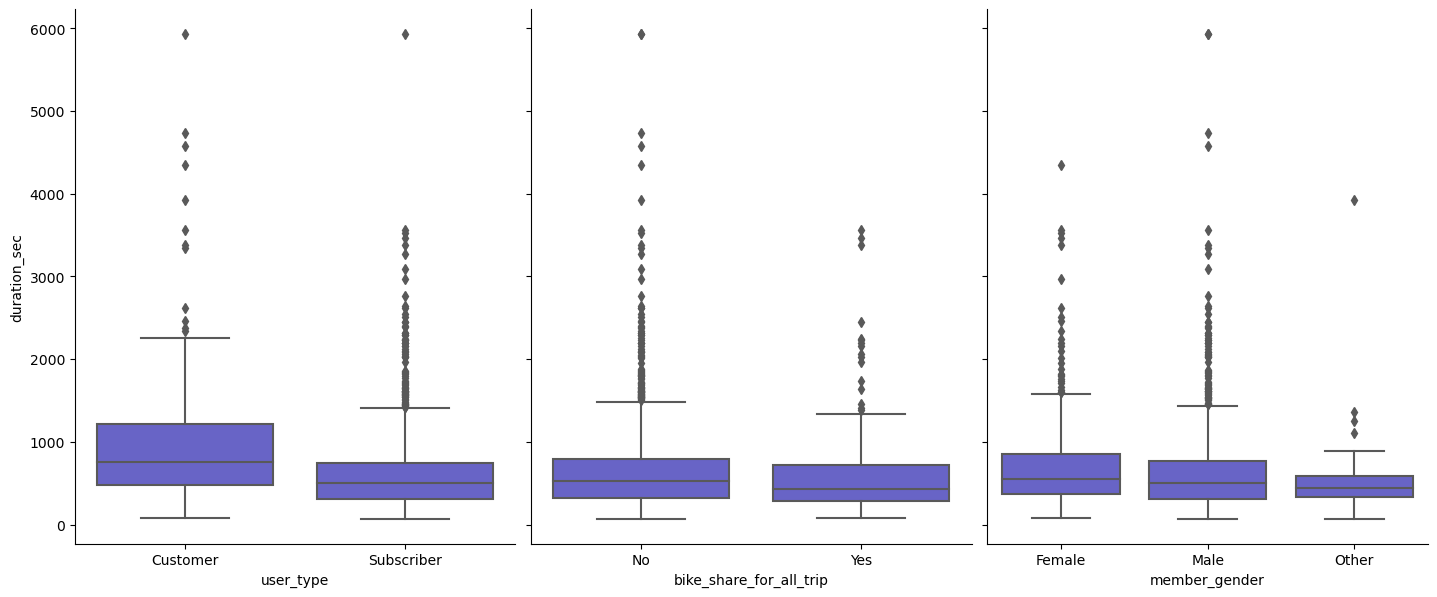

In [38]:
plt.figure(figsize = [15, 8])
g = sb.PairGrid(data = fordbikes_samp, x_vars = cat_columns, y_vars = 'duration_sec',
               size = 6, aspect = 0.8)
g.map(boxgrid)
plt.xticks()
plt.tight_layout(pad=0.8, w_pad=0.8, h_pad=1.0);

Unurprisingly, customers are likely to have high average trip duration due the fact that they to make less frequent trips compared to subscribers. This trend is same with gender as females and other parties because they tend to make less trips.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> I started by looking at the relationship between two numeric variables, trip duration and the age using heatmap. It turns out that most trip were short trips and by the working class and college going students. A positive relationship was observed between customer type and trips duration using heatmap as the percentage of subscriber taken trips was 85% and above. I also observed relationship between 3 categorical variables, user_type, member_gender, bike_share_for_all_trip were males tend to be dominant in all relationships.
Finally, I sampled from the fordbikes dataframe, observed the relationship between trips taken by the categorical variables.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> I observed that unsuscriber or casual riders tend to make 7.5 to 15% of trips made on a daily basis.
> Also, despite the male gender being the most active suscribers, a large chunk of them declined the 'bike_share_for_all_trips' program.

## Multivariate Exploration

Let's look at the relationships between four categorical variables: day, member_gender, user_type and bike_all_for_trip

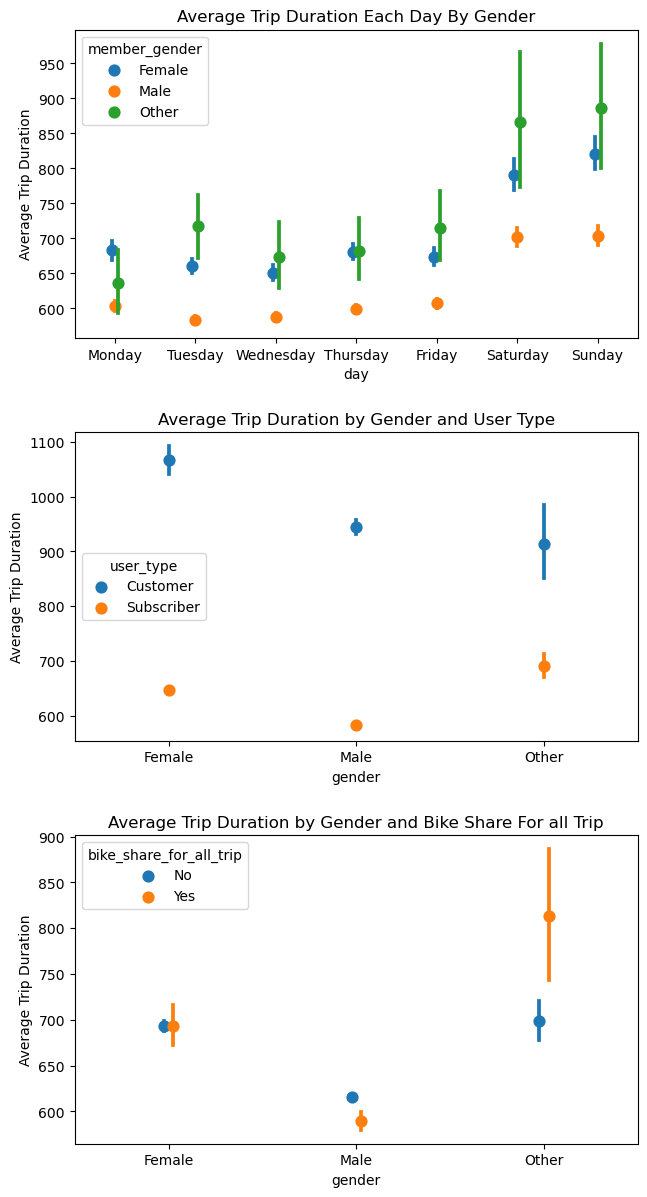

In [39]:
fig, ax = plt.subplots(nrows = 3, figsize = [6.5, 12])

sb.pointplot(data = fordbikes, x = 'day', y = 'duration_sec', hue = 'member_gender', 
             dodge = True, linestyles = " ", ax = ax[0])
ax[0].set_xlabel('day')
ax[0].set_ylabel('Average Trip Duration')
ax[0].set_title('Average Trip Duration Each Day By Gender')

sb.pointplot(data = fordbikes, x = 'member_gender', y = 'duration_sec', hue = 'user_type', linestyles = " ", ax = ax[1])
ax[1].set_xlabel('gender')
ax[1].set_ylabel('Average Trip Duration')
ax[1].set_title('Average Trip Duration by Gender and User Type')

sb.pointplot(data = fordbikes, x = 'member_gender', y = 'duration_sec', dodge = True,
             hue = 'bike_share_for_all_trip', linestyles = " ", ax = ax[2])
ax[2].set_xlabel('gender')
ax[2].set_ylabel('Average Trip Duration')
ax[2].set_title('Average Trip Duration by Gender and Bike Share For all Trip')
plt.tight_layout(pad=0.8, w_pad=0.8, h_pad=2.2);

In the first subplot, it can be observed that males tend to make short trips or they complete trips quicker every single day. Whereas, females and other gender tend to make less but long trips hence leading higher average duration. 
In the second subplot, it can be observed that customers without subscription packages tend to have the highest average trip compared to just subscribers. This pattern is due to the fact that, customers regardless of gender barely take enough trips hence the possibilty to maintain high average trip duration.
In the third subplot, it can be observed that riders in the other gender take the longest trips

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> In this section, I observed the relationship between four categorical variables. From that, I observed the relationship between member gender, user type and day. From visualization, I investigated how this categorcal variables interact with each other when plotted with one numeric variable. 

### Were there any interesting or surprising interactions between features?

> From my the visualization, I observed the average trips taken by member gender on the daily basis. It turned out even though males took more trips, the female and other gender happen to have the highest average trip duration. Moreover, females happen to take long trips compared to other genders, while men take short trips. This is the same for unsuscribers or casual riders.

## Conclusions

 > 1. Go Bike users are largely male dominated. More advertisement needs to geared toward how cycling benefits females and other, to encourage them more.


> 2. Go Bike's subscription packages are more patronized by males


> 3.  Go Bike is popular with office commuters and students


> 4. Go Bike sharing peaks at 8am to 9am during office and school going time and from 5pm to 6pm during closing hours


> 5. Thursdays happens to be most popular with riders, whilst there isn't much biking during weekends


> 6. Most active Go Bike riders are between ages of 25 to 35


> 7. Casual or unsuscribed riders tend to make 7% to 15% of the trips taken each day


> 8. Saturdays have the highest average time spent on trips


> 9. Females and casual riders have the highest trip duration meaning they are more popular with long trips eventhough they take the least trips


> 10. Males are complete trips much more earlier and are likely to take short trips


> 11. People tend to make less trips as they age older. This shows a negative relationship between age and biking


> 12. The dataset is limited to February with just few days in March